# Necessary Libs

In [116]:
# System libs
import os, csv, torch, scipy.io, PIL.Image, torchvision.transforms
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode
from collections import Counter
import matplotlib.pyplot as plt
import cv2
import urllib.request
from tqdm import tqdm

# Download the model weights
- Model can be found at http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-resnet50dilated-ppm_deepsup/

In [117]:
model_weights = 'pretrained_seg_model/ckpt/ade20k-resnet50dilated-ppm_deepsup/'

if not os.path.exists(model_weights):
    os.makedirs(model_weights)

# Check if folder is empty
if not os.listdir(model_weights):
    print("Folder is empty, downloading weights...")
    # Define the download function
    def download_weights(url, filename):
        with tqdm(unit='B', unit_scale=True, unit_divisor=1024, miniters=1, desc=filename) as t:
            urllib.request.urlretrieve(url, model_weights + filename, reporthook=lambda blocks, block_size, total_size: t.update(block_size))

    # Download the encoder weights
    encoder_url = 'http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth'
    encoder_filename = 'encoder_epoch_20.pth'
    download_weights(encoder_url, encoder_filename)

    # Download the decoder weights
    decoder_url = 'http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth'
    decoder_filename = 'decoder_epoch_20.pth'
    download_weights(decoder_url, decoder_filename)

    print("Weights downloaded successfully!")
else:
    print("Folder is not empty, skipping weight download.")


Folder is not empty, skipping weight download.


# Load colors and class names for segmentation

In [118]:
colors = scipy.io.loadmat('pretrained_seg_model/data/color150.mat')['colors']
names = {}
with open('pretrained_seg_model/data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")

In [119]:
names

{1: ['wall'],
 2: ['building', 'edifice'],
 3: ['sky'],
 4: ['floor', 'flooring'],
 5: ['tree'],
 6: ['ceiling'],
 7: ['road', 'route'],
 8: ['bed'],
 9: ['windowpane', 'window'],
 10: ['grass'],
 11: ['cabinet'],
 12: ['sidewalk', 'pavement'],
 13: ['person', 'individual', 'someone', 'somebody', 'mortal', 'soul'],
 14: ['earth', 'ground'],
 15: ['door', 'double', 'door'],
 16: ['table'],
 17: ['mountain', 'mount', 'hill'],
 18: ['plant', 'flora', 'plant', 'life'],
 19: ['curtain', 'drape', 'drapery', 'mantle', 'pall'],
 20: ['chair'],
 21: ['car', 'auto', 'automobile', 'machine', 'motorcar'],
 22: ['water'],
 23: ['painting', 'picture'],
 24: ['sofa', 'couch', 'lounge'],
 25: ['shelf'],
 26: ['house'],
 27: ['sea'],
 28: ['mirror'],
 29: ['rug', 'carpet', 'carpeting'],
 30: ['field'],
 31: ['armchair'],
 32: ['seat'],
 33: ['fence', 'fencing'],
 34: ['desk'],
 35: ['rock', 'stone'],
 36: ['wardrobe', 'closet', 'press'],
 37: ['lamp'],
 38: ['bathtub', 'bathing', 'tub', 'bath', 'tub'],

# Build Encoder-Decoder model

In [120]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='pretrained_seg_model/ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='pretrained_seg_model/ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cpu()

Loading weights for net_encoder
Loading weights for net_decoder


SegmentationModule(
  (encoder): ResnetDilated(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SynchronizedBatchNorm2d(64, eps=1

# Visualization function

In [121]:
def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')
        
    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(np.uint8)

    # aggregate images and save
    im_vis = np.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(im_vis))

# Load one image

In [122]:
# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])
pil_image = PIL.Image.open('captchas/examples/4x4/traffic lights_4.png').convert('RGB')
img_original = np.array(pil_image)
img_data = pil_to_tensor(pil_image)
singleton_batch = {'img_data': img_data[None].cpu()}
output_size = img_data.shape[1:]

# Predict on that image

In [123]:
# Run the segmentation at the highest resolution.
with torch.no_grad():
    scores = segmentation_module(singleton_batch, segSize=output_size)
    
    
# Get the predicted scores for each pixel
_, prediction = torch.max(scores, dim=1)
prediction = prediction.cpu()[0].numpy()

In [124]:
names[prediction[0,0]]

['building', 'edifice']

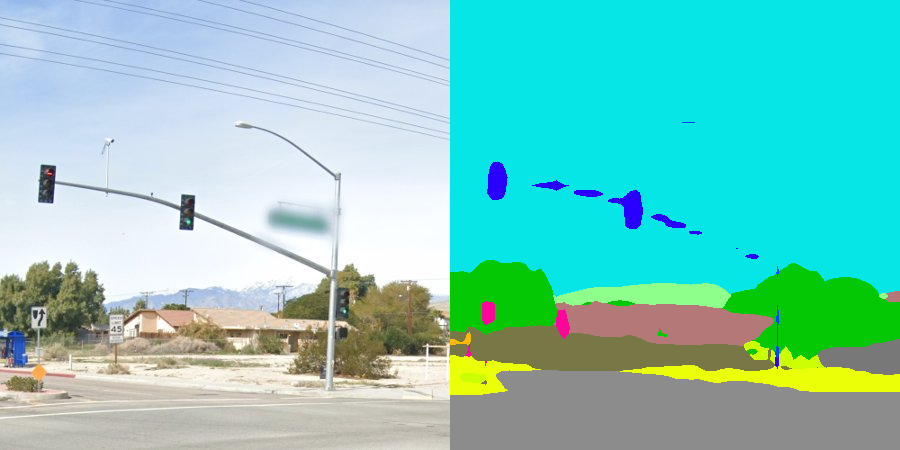

In [125]:
visualize_result(img_original, prediction)

['sky']:


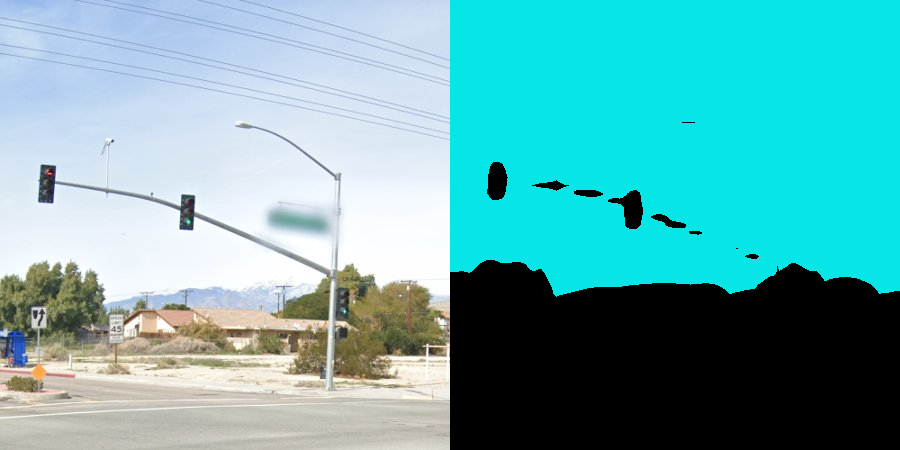

['road', 'route']:


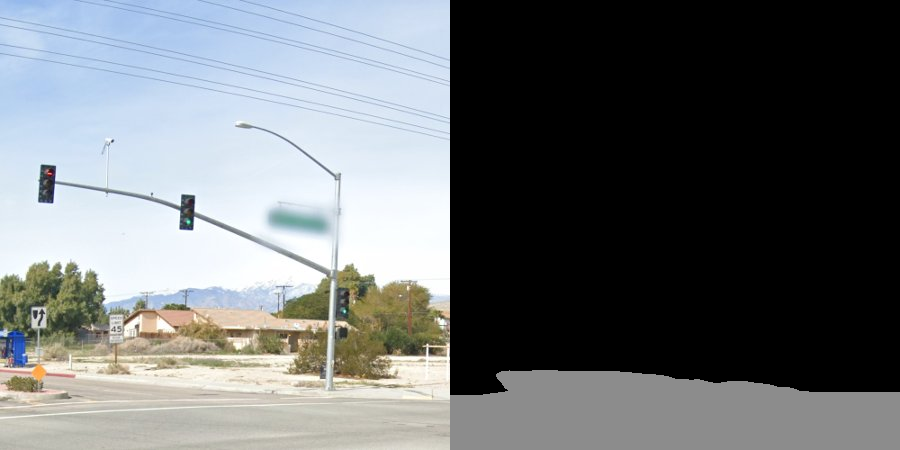

['tree']:


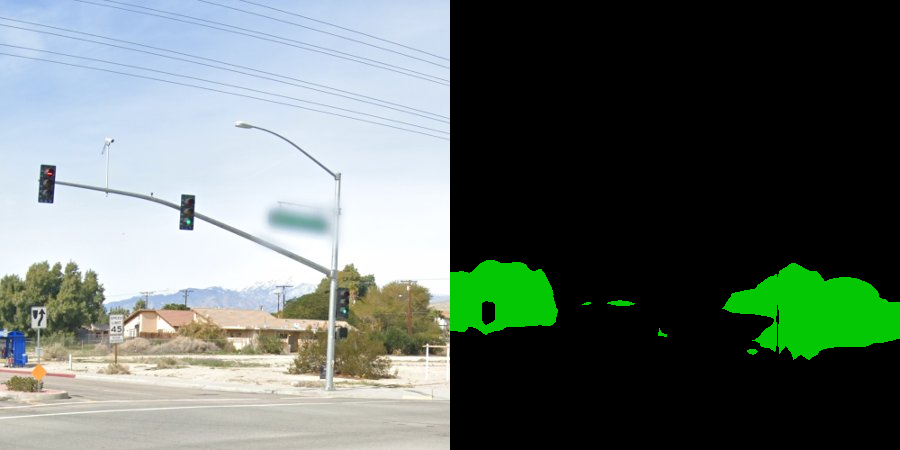

['earth', 'ground']:


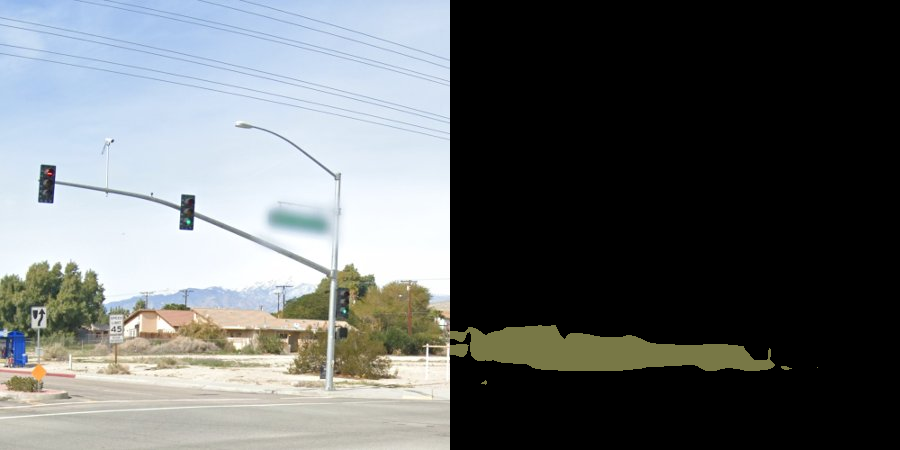

['building', 'edifice']:


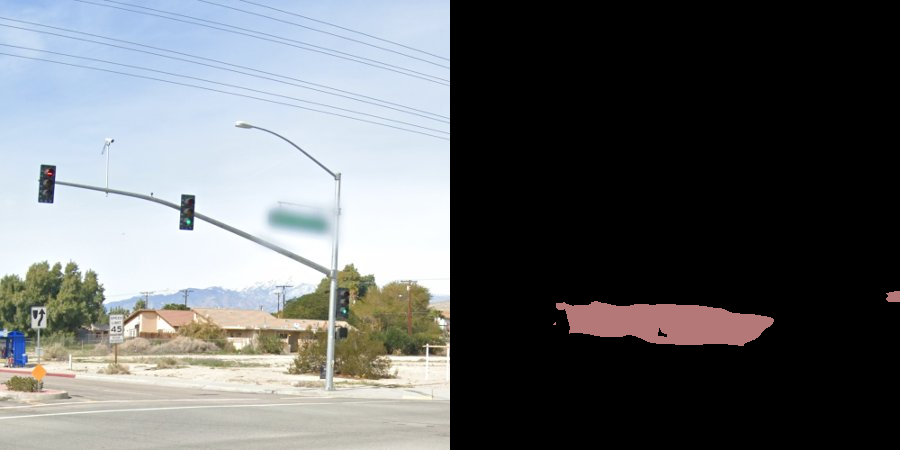

In [126]:
# Top 5 classes in answer
predicted_classes = np.bincount(prediction.flatten()).argsort()[::-1]
for c in predicted_classes[:5]:
    visualize_result(img_original, prediction, c)

# Now that we know our segmentation model works let us actually solve CAPTCHAs

# We need to solve 3 types of CAPTCHAS:

- Google Recaptchas:
  - <br> <img src="https://developers.nopecha.com/static/recaptcha.png" width="600"> <br>
  - These captchas fall into two categories:
    - 3x3 images where there are 9 images within the captcha
    - 4x4 images where one image is segmented into a 4x4 grid

- Alphanumeric captchas:
  - These are outdated but still used
  -  <br> <img src="captchas/letters/2b827.png" width="600"> <br>

# Solving 3x3 Recaptchas

## Convert a 3x3 captcha image to an array of 9 images

In [127]:
def img_to_arr(img_path, n):
    '''
        Takes the path to an image and n, the number of rows and columns in the grid
        Returns an array of n**2, h/n x w/n images
    '''
    image = Image.open(img_path).convert('RGB')
    # Convert the image to a numpy array
    image_array = np.array(image)
    h, w, c = image_array.shape
    # Split the image array into n**2 h/n x w/n sections
    sections = []
    for i in range(n):
        for j in range(n):
            section = image_array[i*h//n:(i+1)*h//n, j*w//n:(j+1)*w//n]
            sections.append(section)
    # Convert the sections list to a numpy array
    sections_array = np.array(sections)
    return sections_array

## Solve 3x3 captcha

In [128]:
def solve_3_x_3(img_path, target_name, confidence, debug=False):
    '''
        Solves a 3x3 recaptcha image.
        img_path: The path to the image to solve.
        target_name: The name of the target class. E.g. "stairs" Target class should be in the 150 classes of the MIT dataset.
        confidence: The confidence threshold. The function will append 'True' if the target class is within the top 'confidence' predictions.
        debug: If True, will visualize the predictions for each square.

        Returns 
            pred_df: A dataframe of the predictions for each square.
            output_list: A list of booleans. True if the target class is in the top 'confidence' predictions for that square. False otherwise.
    '''

    # Define the transformation to apply to each image
    pil_to_tensor = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
            std=[0.229, 0.224, 0.225])  # across a large photo dataset.
    ])

    # Define the output list to return
    output_list = []
    # Define the dictionary of predictions to return
    pred_dict = {}

    img_array = img_to_arr(img_path, 3)
    # Iterate over each image in the array
    enumerate(img_array)
    for idx, img in enumerate(img_array):
        # Convert the image to a tensor and apply the transformation
        pil_image = PIL.Image.fromarray(img)
        img_data = pil_to_tensor(pil_image)
        singleton_batch = {'img_data': img_data[None].cpu()}

        # Run the segmentation model on the image
        with torch.no_grad():
            scores = segmentation_module(singleton_batch, segSize=img_data.shape[1:])
        _, pred = torch.max(scores, dim=1)
        pred = pred.cpu()[0].numpy()

        # Visualize the predictions
        if debug:
            visualize_result(img, pred)

        # Check if the target class is present in the image
        target_class = -1
        for i in range(len(names)):
            if target_name in names[i+1]:
                target_class = i
                break
        if target_class == -1:
            raise ValueError('Target class not found in the class names.')
        
        top_preds = np.argsort(np.bincount(pred.flatten()))[::-1][:confidence]
        top_classes = [names[i+1] for i in top_preds]
        is_present = target_class in top_preds
        
        output_list.append(is_present)
        pred_dict[idx] = {f'Pred #{str(i+1)}': val for i, val in enumerate(top_classes)}
        
    pred_df = pd.DataFrame(pred_dict)
    return output_list, pred_df


## Visualize 3x3 CAPTCHA solving

### Example 1: Car

### Verify car label is in the MIT dataset

In [129]:
"car" in [val for sublist in names.values() for val in sublist]

True

### The dataframe below shows the top 5 predictions for each image on this captcha where we are looking for a car
<img src="captchas/examples/3x3/cars_8.png" width="500">

In [130]:
input_img = 'captchas/examples/3x3/cars_8.png'
output_list, pred_df = solve_3_x_3(img_path=input_img, target_name='car', confidence=5)
print(output_list)
pred_df

[True, False, True, True, False, True, False, False, True]


0  \
Pred #1                                      [road, route]   
Pred #2         [car, auto, automobile, machine, motorcar]   
Pred #3  [person, individual, someone, somebody, mortal...   
Pred #4                                [building, edifice]   
Pred #5                                             [wall]   

                                                         1  \
Pred #1                                [building, edifice]   
Pred #2                                      [road, route]   
Pred #3                               [sidewalk, pavement]   
Pred #4                                              [sky]   
Pred #5  [person, individual, someone, somebody, mortal...   

                                                  2  \
Pred #1                         [building, edifice]   
Pred #2                                      [tree]   
Pred #3                                       [sky]   
Pred #4                               [road, route]   
Pred #5  [car, auto, automobile, machine, motorcar]   

                                                  3                    4  \
Pred #1  [car, auto, automobile, machine, motorcar]                [sky]   
Pred #2                         [building, edifice]  [building, edifice]   
Pred #3                                     [grass]               [tree]   
Pred #4                                       [sky]        [road, route]   
Pred #5                           [floor, flooring]    [signboard, sign]   

                                                  5  \
Pred #1                               [road, route]   
Pred #2                         [building, edifice]   
Pred #3  [car, auto, automobile, machine, motorcar]   
Pred #4                        [sidewalk, pavement]   
Pred #5                                     [grass]   

                                                    6                    7  \
Pred #1                                         [sky]                [sky]   
Pred #2                           [building, edifice]  [building, edifice]   
Pred #3                                        [pole]      [earth, ground]   
Pred #4                                        [tree]               [tree]   
Pred #5  [traffic, light, traffic, signal, stoplight]        [road, route]   

                                                  8  
Pred #1                                       [sky]  
Pred #2                               [road, route]  
Pred #3                         [building, edifice]  
Pred #4                                      [tree]  
Pred #5  [car, auto, automobile, machine, motorcar]

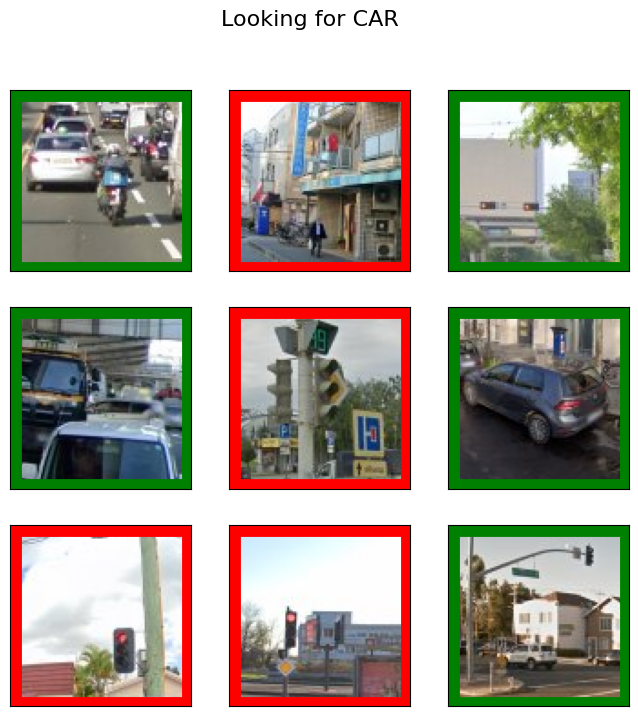

In [131]:
array_img = img_to_arr(input_img, 3)
fig, ax = plt.subplots(3, 3, figsize=(8, 8))
fig.suptitle('Looking for CAR', fontsize=16)
for i, axi in enumerate(ax.flat):
        axi.imshow(array_img[i])
        if output_list[i]:
            axi.add_patch(plt.Rectangle((0, 0), array_img[i].shape[1], array_img[i].shape[0], linewidth=15, edgecolor='g', facecolor='none'))
        else:
            axi.add_patch(plt.Rectangle((0, 0), array_img[i].shape[1], array_img[i].shape[0], linewidth=15, edgecolor='r', facecolor='none'))
        axi.set(xticks=[], yticks=[])
plt.show()

### Another example on a 3x3 captcha

### Example 2: Hills

In [132]:
"hill" in [val for sublist in names.values() for val in sublist]

True

### The dataframe below shows the top 5 predictions for each image on this captcha where we are looking for hills
<img src="captchas/examples/3x3/mountains or hills_7.png" width="500">

In [133]:
input_img = 'captchas/examples/3x3/mountains or hills_7.png'
output_list, pred_df = solve_3_x_3(img_path=input_img, target_name='hill', confidence=10)
print(output_list)
pred_df

[False, False, True, True, False, False, True, False, True]


0  \
Pred #1                          [building, edifice]   
Pred #2                                [road, route]   
Pred #3                                       [tree]   
Pred #4                         [sidewalk, pavement]   
Pred #5                             [pot, flowerpot]   
Pred #6                  [plant, flora, plant, life]   
Pred #7   [car, auto, automobile, machine, motorcar]   
Pred #8                                        [sky]   
Pred #9                             [column, pillar]   
Pred #10                                      [sand]   

                                                          1  \
Pred #1                                 [building, edifice]   
Pred #2                                [sidewalk, pavement]   
Pred #3   [person, individual, someone, somebody, mortal...   
Pred #4                                       [road, route]   
Pred #5                                           [cabinet]   
Pred #6                                             [grass]   
Pred #7                                [windowpane, window]   
Pred #8                                               [bed]   
Pred #9                                           [ceiling]   
Pred #10                                             [tree]   

                                2                        3  \
Pred #1                    [tree]                   [tree]   
Pred #2            [bridge, span]  [mountain, mount, hill]   
Pred #3                     [sky]            [road, route]   
Pred #4   [mountain, mount, hill]      [building, edifice]   
Pred #5                   [grass]                    [sky]   
Pred #6          [fence, fencing]     [door, double, door]   
Pred #7                   [river]                    [bed]   
Pred #8           [earth, ground]        [floor, flooring]   
Pred #9             [road, route]                [ceiling]   
Pred #10                  [chair]     [windowpane, window]   

                                                     4  \
Pred #1                                         [wall]   
Pred #2                              [floor, flooring]   
Pred #3                                          [fan]   
Pred #4                  [bicycle, bike, wheel, cycle]   
Pred #5                         [refrigerator, icebox]   
Pred #6                                   [skyscraper]   
Pred #7                                         [sink]   
Pred #8                                         [sand]   
Pred #9                                      [counter]   
Pred #10  [chest, of, drawers, chest, bureau, dresser]   

                                                          5  \
Pred #1                                 [building, edifice]   
Pred #2                                [sidewalk, pavement]   
Pred #3                                              [tree]   
Pred #4                                       [road, route]   
Pred #5   [person, individual, someone, somebody, mortal...   
Pred #6                                           [cabinet]   
Pred #7                                             [grass]   
Pred #8                                [windowpane, window]   
Pred #9                                               [bed]   
Pred #10                                          [ceiling]   

                                    6  \
Pred #1                        [tree]   
Pred #2             [signboard, sign]   
Pred #3       [mountain, mount, hill]   
Pred #4                        [wall]   
Pred #5               [earth, ground]   
Pred #6                         [sky]   
Pred #7                     [cushion]   
Pred #8                     [cabinet]   
Pred #9   [plant, flora, plant, life]   
Pred #10      [base, pedestal, stand]   

                                                          7  \
Pred #1                                 [building, edifice]   
Pred #2                                       [road, route]   
Pred #3                                [sidewalk, pavement]   
Pred #4          [ca

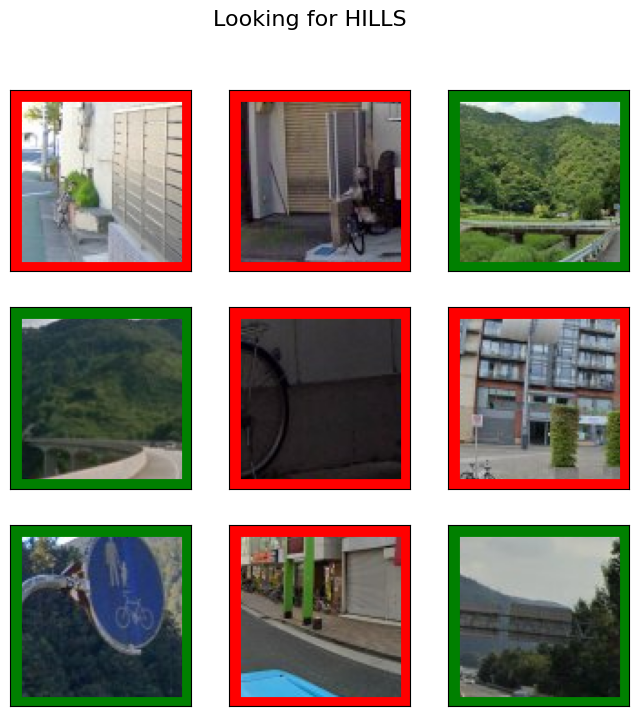

In [134]:
array_img = img_to_arr(input_img, 3)
fig, ax = plt.subplots(3, 3, figsize=(8, 8))
fig.suptitle('Looking for HILLS', fontsize=16)
for i, axi in enumerate(ax.flat):
        axi.imshow(array_img[i])
        if output_list[i]:
            axi.add_patch(plt.Rectangle((0, 0), array_img[i].shape[1], array_img[i].shape[0], linewidth=15, edgecolor='g', facecolor='none'))
        else:
            axi.add_patch(plt.Rectangle((0, 0), array_img[i].shape[1], array_img[i].shape[0], linewidth=15, edgecolor='r', facecolor='none'))
        axi.set(xticks=[], yticks=[])
plt.show()

### Example 2.5: Mountains

In [135]:
"mountain" in [val for sublist in names.values() for val in sublist]

True

In [136]:
input_img = 'captchas/examples/3x3/mountains or hills_7.png'
output_list, pred_df = solve_3_x_3(img_path=input_img, target_name='mountain', confidence=5)
print(output_list)
pred_df

[False, False, True, True, False, False, True, False, True]


0  \
Pred #1   [building, edifice]   
Pred #2         [road, route]   
Pred #3                [tree]   
Pred #4  [sidewalk, pavement]   
Pred #5      [pot, flowerpot]   

                                                         1  \
Pred #1                                [building, edifice]   
Pred #2                               [sidewalk, pavement]   
Pred #3  [person, individual, someone, somebody, mortal...   
Pred #4                                      [road, route]   
Pred #5                                          [cabinet]   

                               2                        3  \
Pred #1                   [tree]                   [tree]   
Pred #2           [bridge, span]  [mountain, mount, hill]   
Pred #3                    [sky]            [road, route]   
Pred #4  [mountain, mount, hill]      [building, edifice]   
Pred #5                  [grass]                    [sky]   

                                     4  \
Pred #1                         [wall]   
Pred #2              [floor, flooring]   
Pred #3                          [fan]   
Pred #4  [bicycle, bike, wheel, cycle]   
Pred #5         [refrigerator, icebox]   

                                                         5  \
Pred #1                                [building, edifice]   
Pred #2                               [sidewalk, pavement]   
Pred #3                                             [tree]   
Pred #4                                      [road, route]   
Pred #5  [person, individual, someone, somebody, mortal...   

                               6                                           7  \
Pred #1                   [tree]                         [building, edifice]   
Pred #2        [signboard, sign]                               [road, route]   
Pred #3  [mountain, mount, hill]                        [sidewalk, pavement]   
Pred #4                   [wall]  [car, auto, automobile, machine, motorcar]   
Pred #5          [earth, ground]                                      [pole]   

                               8  
Pred #1                   [tree]  
Pred #2                    [sky]  
Pred #3      [building, edifice]  
Pred #4            [road, route]  
Pred #5  [mountain, mount, hill]

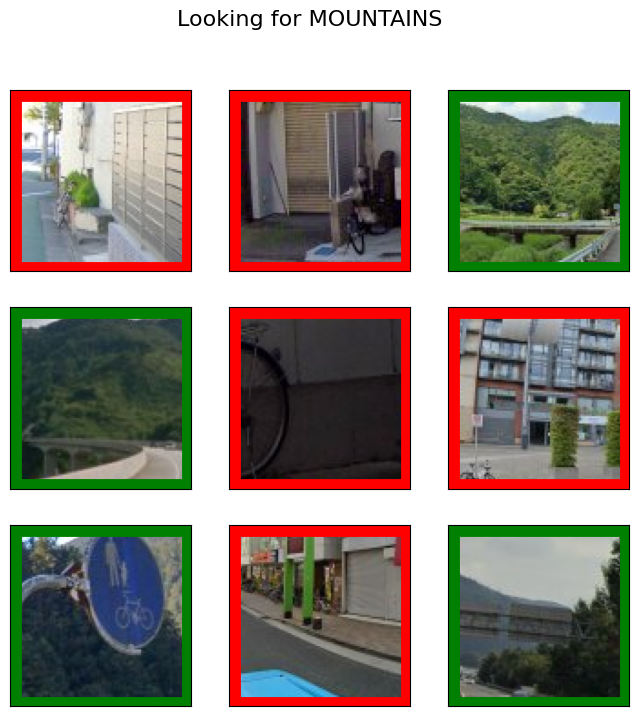

In [137]:
array_img = img_to_arr(input_img, 3)
fig, ax = plt.subplots(3, 3, figsize=(8, 8))
fig.suptitle('Looking for MOUNTAINS', fontsize=16)
for i, axi in enumerate(ax.flat):
        axi.imshow(array_img[i])
        if output_list[i]:
            axi.add_patch(plt.Rectangle((0, 0), array_img[i].shape[1], array_img[i].shape[0], linewidth=15, edgecolor='g', facecolor='none'))
        else:
            axi.add_patch(plt.Rectangle((0, 0), array_img[i].shape[1], array_img[i].shape[0], linewidth=15, edgecolor='r', facecolor='none'))
        axi.set(xticks=[], yticks=[])
plt.show()

# Solving 4x4 Captchas

## Convert an array of nxn predictions into a 4x4 grid
- This will be used for finding the dominant prediction in each square of the grid

In [138]:
def create_grid_pred(arr, n):
    '''
        Takes an array of predictions and n, the number of rows and columns in the grid
        Returns an n x n grid of predictions
    '''
    h, w = arr.shape[:2]
    grid_h, grid_w = n, n
    sub_h, sub_w = h // grid_h, w // grid_w
    grid = np.zeros((grid_h, grid_w, sub_h, sub_w) + arr.shape[2:], dtype=arr.dtype)
    for i in range(grid_h):
        for j in range(grid_w):
            sub_arr = arr[i*sub_h:(i+1)*sub_h, j*sub_w:(j+1)*sub_w]
            grid[i, j] = sub_arr
    return grid

In [139]:
prediction.shape

(450, 450)

In [140]:
create_grid_pred(prediction, 4).shape

(4, 4, 112, 112)

In [141]:
def solve_4x4(img_path, target_name, confidence):
    '''
        Solves a 4x4 recaptcha image.
        img_path: The path to the image to solve.
        target_name: The name of the target class. E.g. "stairs" Target class should be in the 150 classes of the MIT dataset.
        confidence: The confidence threshold. The function will append 'True' if the target class is within the top 'confidence' predictions.
        debug: If True, will visualize the predictions for each square.

        Returns 
            pred_df: A dataframe of the predictions for each square.
            output_list: A list of booleans. True if the target class is in the top 'confidence' predictions for that square. False otherwise.
    '''

    # Define the transformation to apply to the image
    pil_to_tensor = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
            std=[0.229, 0.224, 0.225])  # across a large photo dataset.
    ])

    # Define the output list to return
    output_list = []
    # Define the dictionary of predictions to return
    pred_dict = {}

    # Load the image
    pil_image = PIL.Image.open(img_path).convert('RGB')
    # Convert the image to a numpy array
    img_original = np.array(pil_image)
    # Convert the image to a tensor
    img_data = pil_to_tensor(pil_image)
    # Create a singleton batch
    singleton_batch = {'img_data': img_data[None].cpu()}
    # Get the output size
    output_size = img_data.shape[1:]

    # Run the segmentation at the highest resolution.
    with torch.no_grad():
        scores = segmentation_module(singleton_batch, segSize=output_size)

    # Get the predicted scores for each pixel
    _, pred = torch.max(scores, dim=1)
    pred = pred.cpu()[0].numpy()

    # Create a grid of predictions
    pred_grid = create_grid_pred(pred, 4)

    for r in range(4):
        for c in range(4):
            # Get the prediction for the current square
            pred = pred_grid[r][c]
            # Check if the target class is present in the image
            target_class = -1
            for i in range(len(names)):
                if target_name in names[i+1]:
                    target_class = i
                    break
            if target_class == -1:
                raise ValueError('Target class not found in the class names.')
            
            top_preds = np.argsort(np.bincount(pred.flatten()))[::-1][:confidence]
            top_classes = [names[i+1] for i in top_preds]
            is_present = target_class in top_preds
            
            output_list.append(is_present)
            pred_dict[f'{r},{c}'] = top_classes

    # Get maximum length of arrays in pred_dict
    max_len = max(len(v) for v in pred_dict.values())
    # Pad shorter arrays with NaN values
    d_padded = {k: v + [np.nan]*(max_len - len(v)) for k, v in pred_dict.items()}
    # Convert to dataframe
    pred_df = pd.DataFrame.from_dict(d_padded)
    return output_list, pred_df


## Visualize 4x4 CAPTCHA solving
### Example 1: Bicycle
### Verify bicycle label is in the MIT dataset

In [148]:
"bicycle" in  [val for sublist in names.values() for val in sublist]

True

### The dataframe below shows the top predictions for each image on this captcha where we are looking for a bicycle
<img src="captchas/examples/4x4/bicycles_4.png" width="500">

In [143]:
input_img = 'captchas/examples/4x4/bicycles_4.png'
output_list, pred_df = solve_4x4(input_img, "bicycle", confidence=10)
print(output_list)
pred_df

[False, False, False, False, True, True, True, False, False, True, True, False, False, False, False, False]


0,0  \
0  [car, auto, automobile, machine, motorcar]   
1                 [plant, flora, plant, life]   
2                                      [wall]   
3                                      [tree]   
4                         [building, edifice]   
5                                     [grass]   
6     [curtain, drape, drapery, mantle, pall]   
7                                       [bed]   
8                                       [sky]   
9                           [floor, flooring]   

                                                 0,1  \
0         [car, auto, automobile, machine, motorcar]   
1                                            [grass]   
2                                      [rock, stone]   
3                                             [tree]   
4                                    [earth, ground]   
5                                      [road, route]   
6                               [door, double, door]   
7  [person, individual, someone, somebody, mortal...   
8                               [sidewalk, pavement]   
9                                          [cabinet]   

                                          0,2                  0,3  \
0                                      [tree]               [tree]   
1                                     [grass]    [floor, flooring]   
2                             [earth, ground]                [sky]   
3                                      [pole]  [building, edifice]   
4                     [mountain, mount, hill]               [wall]   
5                               [rock, stone]                  NaN   
6                               [road, route]                  NaN   
7  [car, auto, automobile, machine, motorcar]                  NaN   
8                 [plant, flora, plant, life]                  NaN   
9                    [rug, carpet, carpeting]                  NaN   

                                                 1,0  \
0         [car, auto, automobile, machine, motorcar]   
1                                             [tree]   
2  [person, individual, someone, somebody, mortal...   
3                                            [grass]   
4                      [bicycle, bike, wheel, cycle]   
5                                          [counter]   
6       [chest, of, drawers, chest, bureau, dresser]   
7                                  [signboard, sign]   
8                                   [column, pillar]   
9                                              [box]   

                                                 1,1  \
0  [person, individual, someone, somebody, mortal...   
1         [car, auto, automobile, machine, motorcar]   
2                                            [grass]   
3                      [bicycle, bike, wheel, cycle]   
4                                   [column, pillar]   
5                                          [counter]   
6       [chest, of, drawers, chest, bureau, dresser]   
7                                  [signboard, sign]   
8                                              [box]   
9                                             [sink]   

                                                 1,2                   1,3  \
0                                            [grass]                [tree]   
1  [person, individual, someone, somebody, mortal...               [grass]   
2                      [bicycle, bike, wheel, cycle]  [windowpane, window]   
3                                             [tree]                 [bed]   
4                                      [road, route]         [road, route]   
5         [car, auto, automobile, machine, motorcar]             [ceiling]   
6                                   [column, pillar]     [floor, flooring]   
7                                             [sand]                 [sky]   
8                                          [counter]   [building, edifice]   
9       [chest, of, drawers, chest, bureau, dresser]                [wall]   

                     

/var/folders/3x/vqcykbm5477c2ks1kh1yzcbr0000gn/T/ipykernel_7939/3180695521.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sections_array = np.array(sections)


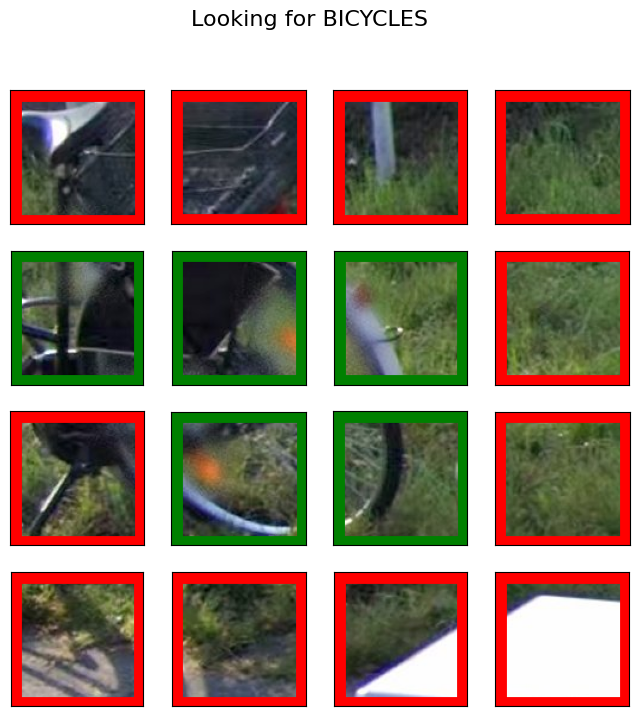

In [144]:
array_img = img_to_arr(input_img, 4)
fig, ax = plt.subplots(4, 4, figsize=(8, 8))
for i, axi in enumerate(ax.flat):
        axi.imshow(array_img[i])
        if output_list[i]:
            axi.add_patch(plt.Rectangle((0, 0), array_img[i].shape[1], array_img[i].shape[0], linewidth=15, edgecolor='g', facecolor='none'))
        else:
            axi.add_patch(plt.Rectangle((0, 0), array_img[i].shape[1], array_img[i].shape[0], linewidth=15, edgecolor='r', facecolor='none'))
        axi.set(xticks=[], yticks=[])
plt.suptitle('Looking for BICYCLES', fontsize=16)
plt.show()

## Visualize 4x4 CAPTCHA solving
### Example 2: Bus
### Verify bus label is in the MIT dataset

In [149]:
"bus" in  [val for sublist in names.values() for val in sublist]

True

### The dataframe below shows the top predictions for each image on this captcha where we are looking for a bus
<img src="captchas/examples/4x4/buses_3.png" width=500 />

In [146]:
input_img = 'captchas/examples/4x4/buses_3.png'
output_list, pred_df = solve_4x4(input_img, "bus", confidence=10)
print(output_list)
pred_df

[False, False, False, False, False, False, False, False, False, False, True, True, False, False, True, True]


0,0                          0,1  \
0                [sky]                        [sky]   
1  [building, edifice]                       [pole]   
2               [wall]  [streetlight, street, lamp]   
3                  NaN                [rock, stone]   
4                  NaN                      [house]   
5                  NaN                        [sea]   
6                  NaN                     [mirror]   
7                  NaN     [rug, carpet, carpeting]   
8                  NaN                      [field]   
9                  NaN                   [armchair]   

                           0,2                  0,3                  1,0  \
0                        [sky]                [sky]                [sky]   
1  [streetlight, street, lamp]  [building, edifice]  [building, edifice]   
2                       [pole]               [wall]               [wall]   
3                [rock, stone]                  NaN                  NaN   
4                      [house]                  NaN                  NaN   
5                        [sea]                  NaN                  NaN   
6                     [mirror]                  NaN                  NaN   
7     [rug, carpet, carpeting]                  NaN                  NaN   
8                      [field]                  NaN                  NaN   
9                   [armchair]                  NaN                  NaN   

                           1,1                          1,2  \
0                        [sky]                        [sky]   
1                       [pole]                       [tree]   
2  [streetlight, street, lamp]  [streetlight, street, lamp]   
3                       [tree]                       [pole]   
4                [rock, stone]                [rock, stone]   
5                      [house]                      [house]   
6                        [sea]                        [sea]   
7                     [mirror]                     [mirror]   
8     [rug, carpet, carpeting]     [rug, carpet, carpeting]   
9                      [field]                      [field]   

                           1,3                          2,0  \
0                        [sky]          [building, edifice]   
1                       [tree]                        [sky]   
2                       [pole]  [plant, flora, plant, life]   
3  [streetlight, street, lamp]         [sidewalk, pavement]   
4          [building, edifice]                [road, route]   
5                [rock, stone]            [signboard, sign]   
6                        [sea]             [fence, fencing]   
7                     [mirror]                       [tree]   
8     [rug, carpet, carpeting]                        [box]   
9                      [field]                    [ceiling]   

                                          2,1  \
0                         [building, edifice]   
1                 [plant, flora, plant, life]   
2                                      [tree]   
3  [car, auto, automobile, machine, motorcar]   
4                                       [sky]   
5                                      [pole]   
6                               [road, route]   
7                        [sidewalk, pavement]   
8                             [railing, rail]   
9                                      [wall]   

                                                 2,2  \
0  [bus, autobus, coach, charabanc, double-decker...   
1                                             [tree]   
2                        [plant, flora, plant, life]   
3                                              [van]   
4                                      [road, route]   
5         [car, auto, automobile, machine, motorcar]   
6                                             [wall]   
7                                   [fence, fencing]   
8                                    [railing, rail]   
9  [bannister, banister, balustrade, balusters, h...   

                               

/var/folders/3x/vqcykbm5477c2ks1kh1yzcbr0000gn/T/ipykernel_7939/3180695521.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sections_array = np.array(sections)


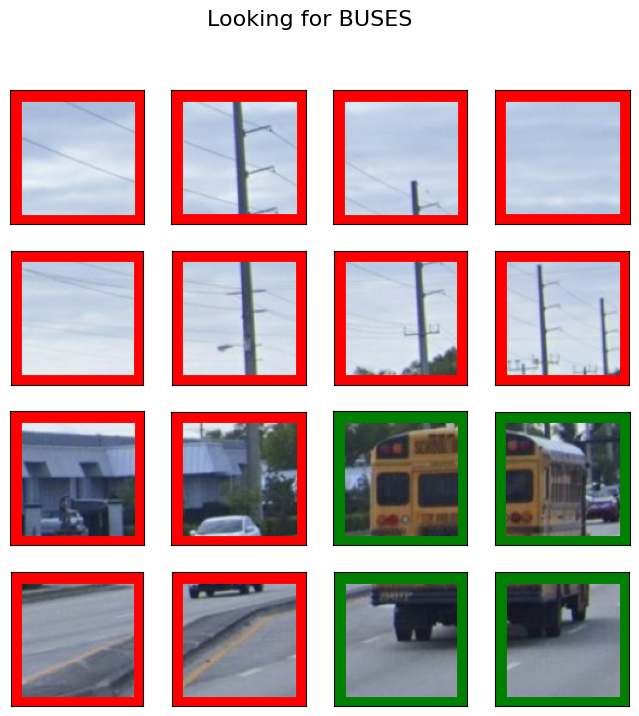

In [147]:
array_img = img_to_arr(input_img, 4)
fig, ax = plt.subplots(4, 4, figsize=(8, 8))
for i, axi in enumerate(ax.flat):
        axi.imshow(array_img[i])
        if output_list[i]:
            axi.add_patch(plt.Rectangle((0, 0), array_img[i].shape[1], array_img[i].shape[0], linewidth=15, edgecolor='g', facecolor='none'))
        else:
            axi.add_patch(plt.Rectangle((0, 0), array_img[i].shape[1], array_img[i].shape[0], linewidth=15, edgecolor='r', facecolor='none'))
        axi.set(xticks=[], yticks=[])
plt.suptitle('Looking for BUSES', fontsize=16)
plt.show()

## Visualize 4x4 CAPTCHA solving
### Example 3: Stoplight
### Verify stoplight label is in the MIT dataset

In [150]:
'stoplight' in [val for sublist in names.values() for val in sublist]

True

### The dataframe below shows the top predictions for each image on this captcha where we are looking for traffic lights
<img src="captchas/examples/4x4/traffic lights_4.png" width=500 />

In [154]:
input_img = 'captchas/examples/4x4/traffic lights_4.png'
output_list, pred_df = solve_4x4(input_img, "stoplight", confidence=10)
print(output_list)
pred_df

[False, False, False, False, True, True, True, False, False, True, True, False, False, False, False, False]


0,0                  0,1                  0,2  \
0                [sky]                [sky]                [sky]   
1  [building, edifice]  [building, edifice]  [building, edifice]   
2               [wall]               [wall]               [wall]   
3                  NaN                  NaN                  NaN   
4                  NaN                  NaN                  NaN   
5                  NaN                  NaN                  NaN   
6                  NaN                  NaN                  NaN   
7                  NaN                  NaN                  NaN   
8                  NaN                  NaN                  NaN   
9                  NaN                  NaN                  NaN   

                   0,3                                           1,0  \
0                [sky]                                         [sky]   
1  [building, edifice]  [traffic, light, traffic, signal, stoplight]   
2               [wall]                              [column, pillar]   
3                  NaN                                  [skyscraper]   
4                  NaN                                        [sink]   
5                  NaN                                        [sand]   
6                  NaN                                     [counter]   
7                  NaN  [chest, of, drawers, chest, bureau, dresser]   
8                  NaN                             [signboard, sign]   
9                  NaN                                         [box]   

                                            1,1  \
0                                         [sky]   
1  [traffic, light, traffic, signal, stoplight]   
2                              [column, pillar]   
3                                  [skyscraper]   
4                                        [sink]   
5                                        [sand]   
6                                     [counter]   
7  [chest, of, drawers, chest, bureau, dresser]   
8                             [signboard, sign]   
9                                         [box]   

                                            1,2                  1,3  \
0                                         [sky]                [sky]   
1  [traffic, light, traffic, signal, stoplight]  [building, edifice]   
2                   [streetlight, street, lamp]               [wall]   
3                             [signboard, sign]                  NaN   
4                                  [skyscraper]                  NaN   
5                                        [sink]                  NaN   
6                                        [sand]                  NaN   
7                                     [counter]                  NaN   
8  [chest, of, drawers, chest, bureau, dresser]                  NaN   
9                              [column, pillar]                  NaN   

                       2,0                                           2,1  \
0                   [tree]                                         [sky]   
1                    [sky]                           [building, edifice]   
2          [earth, ground]                       [mountain, mount, hill]   
3        [signboard, sign]                                        [tree]   
4  [mountain, mount, hill]                             [signboard, sign]   
5      [building, edifice]  [traffic, light, traffic, signal, stoplight]   
6         [fence, fencing]                               [earth, ground]   
7            [road, route]                                     [cushion]   
8                    [bed]                       [base, pedestal, stand]   
9     [windowpane, window]                                         [box]   

                                            2,2                      2,3  \
0                                         [sky]                   [tree]   
1                           [building, edifice]                    [sky]   
2                                        [tree]      [bui

/var/folders/3x/vqcykbm5477c2ks1kh1yzcbr0000gn/T/ipykernel_7939/3180695521.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sections_array = np.array(sections)


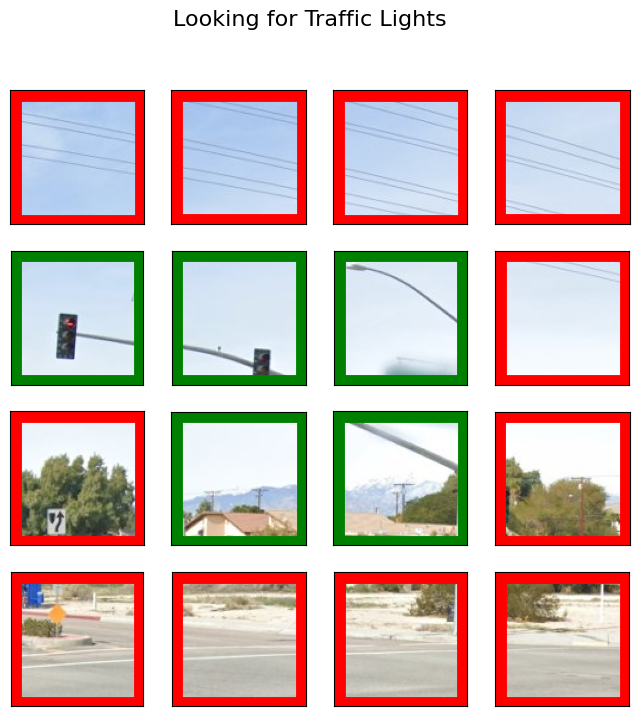

In [156]:
array_img = img_to_arr(input_img, 4)
fig, ax = plt.subplots(4, 4, figsize=(8, 8))
for i, axi in enumerate(ax.flat):
        axi.imshow(array_img[i])
        if output_list[i]:
            axi.add_patch(plt.Rectangle((0, 0), array_img[i].shape[1], array_img[i].shape[0], linewidth=15, edgecolor='g', facecolor='none'))
        else:
            axi.add_patch(plt.Rectangle((0, 0), array_img[i].shape[1], array_img[i].shape[0], linewidth=15, edgecolor='r', facecolor='none'))
        axi.set(xticks=[], yticks=[])
plt.suptitle('Looking for Traffic Lights', fontsize=16)
plt.show()

# Conclusions

- Many classes in CAPTCHAs exist in the MIT dataset
- To move forward with this we will need to be able to translate Google's captcha prompts into a class our model can work with
- We may also need to add onto this model so it specialized on reCaptcha tasks